<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_image3 pipeline. At the end of the calwebb_image3 pipeline, the set of files defined in an association table will be distortion corrected and combined. Resample is the step that applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Image+Combination


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with multiple point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates.

### Create the data for testing

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). Referring to the MIRISim link, you can see how to set up and run the simulator to re-create the input files if you wish. The data was run with a scene.ini file that specified what the scene should look like, with coordinates for the stars given in units of arcsecond offsets from the center of the field of view. The scene.ini file as well as the setup files simuation.ini and simulator.ini are needed to run the simulation.

Once in the mirisim conda environment, the simulation is run with the command line:
> mirisim simulation.ini

The simulator created four files, two exposures each at two different dither positions, using the specified filter. Make sure the WCSAXES header keyword in the SCI extension is set to 2 and not 4. If it is set to 4, change it to 2.



[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The four files were then run individually through the calwebb_detector1 and calwebb_image2 pipelines. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 10 sigma to avoid a current issue where the jump detection step flags a large percentage of pixels as jumps. This can be done on the command line. (commands to be typed start with $)

The pipelines can be run on the command line with the following commands or put into a script while using the pipeline conda environment.

$ strun calwebb_detector1.cfg filename --steps.jump.rejection_threshold 10.0

The output of the calwebb_detector1 pipeline is a set of four *rate.fits files which will then be run through the calwebb_image2 pipeline.

$ strun calwebb_image2.cfg filename

The output of the calwebb_image2 pipeline was then a set of four *cal.fits files. An association table was created that included these four files as input, and then the files and the association table were run through the calwebb_image3 pipeline. 

The cal files are stored in artifactory, and this notebook is meant to pull those files for the test of resample. Step through the cells of this notebook to run calwebb_image3 and then check the alignment.



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)


<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* astropy.stats for sigma clipping routine
* astropy.visualization for image plotting
* ci_watson.artifactory_helpers to read in data from artifactory
* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* jwst.associations to create association table
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry
* regtest to retrieve data from artifactory needed to run notebook


[Top of Page](#title_ID)

In [2]:
from astropy.io import ascii, fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from ci_watson.artifactory_helpers import get_bigdata
from itertools import product
from jwst.datamodels import DrizProductModel, ImageModel
from jwst.pipeline import Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry
from jwst.regtest.regtestdata import RegtestData

<a id="runpipeline_ID"></a>
# Open an association table for your cal files and run them through calwebb_image3

Load the association table to use the .cal files that were output from calwebb_image2. That will be the input for calwebb_image3 that uses the resample step to combine each of the individual images.

[Top of Page](#title_ID)

In [3]:
# Use regtest infrastructure to access all input files associated with the association file

rtdata = RegtestData(inputs_root="jwst_validation_notebooks", env="validation_data")
rtdata.get_asn("resample/resample_miri_test/starfield_50star4ptdither_771_asnfile.json")
rtdata.input #this should be the list of files associated with the asn

'/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4/starfield_50star4ptdither_771_asnfile.json'

In [4]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=2.5  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 250 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
#pipe3.skymatch.skip = True        # test to see if this affects the final output
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

im = pipe3.run(rtdata.input)

2021-03-16 23:02:25,543 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-03-16 23:02:25,544 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-03-16 23:02:25,546 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-03-16 23:02:25,548 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-03-16 23:02:25,549 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-03-16 23:02:25,551 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-03-16 23:02:25,552 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-03-16 23:02:25,654 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4/starfield_50star4ptdither_771_asnfile.json',).


2021-03-16 23:02:25,659 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 250, 'brightest':

2021-03-16 23:02:25,981 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-03-16 23:02:27,365 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-03-16 23:02:27,367 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-03-16 23:02:27,368 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-03-16 23:02:27,369 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-03-16 23:02:28,148 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-03-16 23:02:28,150 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 250, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-03-16 23:02:28,418 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal.fits.


2021-03-16 23:02:28,669 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal.fits.


2021-03-16 23:02:29,008 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal.fits.


2021-03-16 23:02:29,335 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal.fits.


2021-03-16 23:02:29,596 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal.fits.


2021-03-16 23:02:29,839 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal.fits.


2021-03-16 23:02:30,251 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal.fits.


2021-03-16 23:02:30,505 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal.fits.


2021-03-16 23:02:30,518 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:30,519 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-03-16 23:02:30,519 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-03-16 23:02:30,545 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal':


2021-03-16 23:02:30,545 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal


2021-03-16 23:02:30,567 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal':


2021-03-16 23:02:30,568 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal


2021-03-16 23:02:30,590 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal':


2021-03-16 23:02:30,591 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal


2021-03-16 23:02:30,614 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal':


2021-03-16 23:02:30,614 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal


2021-03-16 23:02:30,637 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal':


2021-03-16 23:02:30,637 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal


2021-03-16 23:02:30,661 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal':


2021-03-16 23:02:30,661 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal


2021-03-16 23:02:30,683 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal':


2021-03-16 23:02:30,684 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal


2021-03-16 23:02:30,707 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal':


2021-03-16 23:02:30,708 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal


2021-03-16 23:02:30,708 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:30,708 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-03-16 23:02:30,709 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-03-16 23:02:30.708744


2021-03-16 23:02:30,709 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.1


2021-03-16 23:02:30,709 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-03-16 23:02:30,877 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' as reference image


2021-03-16 23:02:30,882 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal' to the reference catalog.


2021-03-16 23:02:30,972 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:30,974 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal'...


2021-03-16 23:02:30,974 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:30,976 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal:


2021-03-16 23:02:30,977 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -4.14982e-05  YSH: -2.92043e-05


2021-03-16 23:02:30,977 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:30,977 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00038568   FIT MAE: 0.000335022


2021-03-16 23:02:30,978 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-03-16 23:02:31,014 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal' to the reference catalog.


2021-03-16 23:02:31,108 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:31,109 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal'...


2021-03-16 23:02:31,110 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:31,112 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal:


2021-03-16 23:02:31,113 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000196935  YSH: -0.000376779


2021-03-16 23:02:31,113 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:31,113 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00423412   FIT MAE: 0.00345647


2021-03-16 23:02:31,114 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-03-16 23:02:31,151 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal' to the reference catalog.


2021-03-16 23:02:31,367 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:31,368 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal'...


2021-03-16 23:02:31,369 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:31,371 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal:


2021-03-16 23:02:31,371 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000207138  YSH: -0.0003959


2021-03-16 23:02:31,372 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:31,372 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00423887   FIT MAE: 0.00345895


2021-03-16 23:02:31,372 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-03-16 23:02:31,410 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal' to the reference catalog.


2021-03-16 23:02:31,575 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:31,577 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal'...


2021-03-16 23:02:31,578 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:31,581 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal:


2021-03-16 23:02:31,583 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -7.28506e-05  YSH: 0.000891363


2021-03-16 23:02:31,583 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:31,584 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00673656   FIT MAE: 0.00570338


2021-03-16 23:02:31,584 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-03-16 23:02:31,650 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal' to the reference catalog.


2021-03-16 23:02:31,762 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:31,763 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal'...


2021-03-16 23:02:31,764 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:31,765 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal:


2021-03-16 23:02:31,766 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -4.20279e-05  YSH: 0.000945393


2021-03-16 23:02:31,766 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:31,767 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00671488   FIT MAE: 0.00568011


2021-03-16 23:02:31,767 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-03-16 23:02:31,805 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal' to the reference catalog.


2021-03-16 23:02:31,901 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:31,902 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal'...


2021-03-16 23:02:31,903 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:31,905 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal:


2021-03-16 23:02:31,905 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.00011659  YSH: 0.00209105


2021-03-16 23:02:31,905 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:31,906 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00955805   FIT MAE: 0.00597273


2021-03-16 23:02:31,906 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-03-16 23:02:31,943 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal' to the reference catalog.


2021-03-16 23:02:32,039 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal' catalog.


2021-03-16 23:02:32,040 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal'...


2021-03-16 23:02:32,040 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-03-16 23:02:32,043 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal:


2021-03-16 23:02:32,043 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000363848  YSH: 0.00212325


2021-03-16 23:02:32,043 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-03-16 23:02:32,044 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00953981   FIT MAE: 0.0059316


2021-03-16 23:02:32,044 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-03-16 23:02:32,081 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-03-16 23:02:32,082 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-03-16 23:02:32.081550


2021-03-16 23:02:32,082 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.372806


2021-03-16 23:02:32,082 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-03-16 23:02:32,247 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-03-16 23:02:32,401 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-03-16 23:02:32,404 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-03-16 23:02:32,455 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:32,455 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-03-16 23:02:32.455344


2021-03-16 23:02:32,456 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:32,456 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-03-16 23:02:32,456 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-03-16 23:02:32,457 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-03-16 23:02:32,457 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:32,457 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-03-16 23:02:40,063 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 0.00577162


2021-03-16 23:02:40,065 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 0.00237166


2021-03-16 23:02:40,065 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 0.0104688


2021-03-16 23:02:40,065 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 0.00899421


2021-03-16 23:02:40,066 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 0.00465037


2021-03-16 23:02:40,066 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 0.00563079


2021-03-16 23:02:40,066 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 0


2021-03-16 23:02:40,067 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 0.00863079


2021-03-16 23:02:40,067 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:40,067 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-03-16 23:02:40,224 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:40,225 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.38751409470849 [not converted]


2021-03-16 23:02:40,225 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:40,228 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-03-16 23:02:40,228 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 10.3933 (old=0.00577162, delta=10.3875)


2021-03-16 23:02:40,228 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 10.3899 (old=0.00237166, delta=10.3875)


2021-03-16 23:02:40,229 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 10.398 (old=0.0104688, delta=10.3875)


2021-03-16 23:02:40,229 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 10.3965 (old=0.00899421, delta=10.3875)


2021-03-16 23:02:40,229 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 10.3922 (old=0.00465037, delta=10.3875)


2021-03-16 23:02:40,230 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 10.3931 (old=0.00563079, delta=10.3875)


2021-03-16 23:02:40,230 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_cal.fits. Sky background: 10.3875 (old=0, delta=10.3875)


2021-03-16 23:02:40,230 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_cal.fits. Sky background: 10.3961 (old=0.00863079, delta=10.3875)


2021-03-16 23:02:40,231 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:40,231 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-03-16 23:02:40.231115


2021-03-16 23:02:40,231 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:07.775771


2021-03-16 23:02:40,232 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-16 23:02:40,237 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-03-16 23:02:40,357 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-03-16 23:02:40,359 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-03-16 23:02:40,362 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2021-03-16 23:02:41,186 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:42,653 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:44,015 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:45,566 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:47,276 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:48,740 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:50,023 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:51,299 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:02:52,248 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 8 images


2021-03-16 23:02:52,820 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



2021-03-16 23:02:53,028 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-03-16 23:02:53,819 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:02:55,078 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:02:56,202 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:02:57,299 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:02:58,554 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:02:59,987 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:03:01,146 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:03:02,409 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-03-16 23:03:02,678 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:424: RuntimeWarning: overflow encountered in square
  ta = np.sqrt(np.abs(blot_data) + err_data ** 2)



2021-03-16 23:03:04,308 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_b771_a3001_crf.fits


2021-03-16 23:03:04,547 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_b771_a3001_crf.fits


2021-03-16 23:03:04,752 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_b771_a3001_crf.fits


2021-03-16 23:03:04,961 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_b771_a3001_crf.fits


2021-03-16 23:03:05,167 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_b771_a3001_crf.fits


2021-03-16 23:03:05,372 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_b771_a3001_crf.fits


2021-03-16 23:03:05,600 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_b771_a3001_crf.fits


2021-03-16 23:03:06,091 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_b771_a3001_crf.fits


2021-03-16 23:03:06,092 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-03-16 23:03:06,205 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-03-16 23:03:06,206 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-03-16 23:03:06,218 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-03-16 23:03:06,369 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for /ifs/jwst/wit/miri/pipelinetests/cracraft/build7_6/starfield_50star4ptdither_771_combined.fits


2021-03-16 23:03:07,509 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:08,764 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:10,031 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:11,430 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:13,117 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:14,658 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:16,241 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:17,733 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-03-16 23:03:18,166 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-03-16 23:03:18,168 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021512987 -0.020377351 0.024586139 0.014641946 359.990548117 0.017628986 359.987474964 -0.017390311


2021-03-16 23:03:18,646 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_771_combined_i2d.fits


2021-03-16 23:03:18,646 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-03-16 23:03:18,741 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_771_combined_i2d.fits>,).


2021-03-16 23:03:18,743 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe8j3wxf4', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-03-16 23:03:18,757 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-03-16 23:03:18,765 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-03-16 23:03:18,765 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-03-16 23:03:18,766 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-03-16 23:03:18,766 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-03-16 23:03:18,766 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-03-16 23:03:18,801 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-03-16 23:03:19,307 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 587 sources


2021-03-16 23:03:24,191 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_771_combined_cat.ecsv


2021-03-16 23:03:24,239 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_771_combined_segm.fits


2021-03-16 23:03:24,240 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_771_combined_segm.fits


2021-03-16 23:03:24,241 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-03-16 23:03:24,242 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


<a id="runscript_ID"></a>
# Find stars in image and determine their coordinates

The output of the pipeline command in the previous step (given our association table) is an i2d.fits file. This file is in the format of a JWST Data model type of DrizProductModel and should be opened as such. It is this file that we will use for source finding and to determine whether the stars are found in the expected locations. The i2d file and the associated text file containing the input coordinates of the stars can be found in artifactory.

[Top of Page](#title_ID)

#### Read in combined i2d data file and list of coordinates

In [5]:
# Read in the combined data file and list of coordinates

im = ImageModel('starfield_50star4ptdither_771_combined_i2d.fits')

coords = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'resample',
                     'resample_miri_test', 
                     'radec_4ptdith_50star_mosaic_coords.txt')

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print(mean, median, std)

2021-03-16 23:03:24,248 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



1.9009567 0.0030555231 44.11985


#### Run DAOStar finder to find sources in the image and examine the image and positions marked. 
The block of code below will find the sources in the image, create apertures for each source found, and output the table of x, y coordinates along with the peak pixel value. It will also show a scaled version of the image and mark in blue the positions of sources found.


2021-03-16 23:03:24,536 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-03-16 23:03:24,636 - stpipe - WARNING - <ipython-input-1-56bf342f74ee>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(data, cmap='Greys', origin='lower', vmin=-15,vmax=10, norm=norm)



    xcentroid          ycentroid             peak      
------------------ ------------------ -----------------
  684.040628170083 127.52921894709756  2498.78857421875
 761.1452939524696  131.0097871176564 2620.199462890625
  962.038578131555 156.26754902571167 2489.147216796875
 1029.538625968008 160.76018813336432  2508.25244140625
 520.1426056329431 187.63936980893487  2498.20947265625
 784.3358989523381  197.0881050055314 2576.111083984375
449.52302034974014  208.5748318176676   2324.7685546875
504.97834877759584 222.21148712108027  2614.68115234375
 562.1914576820818  235.7944897794482 2615.638427734375
  888.869869486881  258.1111198190123     2659.41015625
               ...                ...               ...
 554.2068778465253  911.9355815547236 2657.637939453125
 895.8519168091127  968.8878656968843 2658.355224609375
 851.0540370612621  975.2978573976739 2658.151123046875
 896.6190203384306  984.1551986486409     2562.08984375
1053.8558651020874 1028.4913460317084  2451.5151

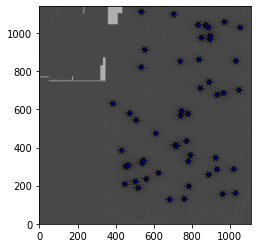

In [6]:
# Run DAOStarFinder to find sources in image

ap_radius = 4.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    
print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)

# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.imshow(data, cmap='Greys', origin='lower', vmin=-15,vmax=10, norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

#### Run photometry on apertures (with a specified annulus for background subtraction)

Set a specified annulus (inner and outer radii for the annulus).

Run photometry on aperture and annuli.

Subtract background values in annulus from aperture photometry.

Output should be a table of photometry values printed to the screen (full table has columns id, xcenter, ycenter, aperture_sum and the added columns annulus_median, aperture_bkg and aperture_sum_bkgsub). You can choose which columns you wish to see printed.

In [7]:
# set values for inner and outer annuli to collect background counts

inner_annulus = 10.
outer_annulus = 15.

# set up annulus for background
background_aper = CircularAnnulus(positions, r_in=inner_annulus, r_out=outer_annulus)

# perform photometry on apertures for targets and background annuli
phot_table = aperture_photometry(im.data, apertures)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask = background_aper.to_mask(method='center')
bmask = bkg_mask[0]
for mask in bkg_mask:
    aper_data = bmask.multiply(data)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table['aperture_bkg'] = bkg_median * apertures.area
# subtract background in aperture from flux in aperture
phot_table['aperture_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aperture_bkg']

print(phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub'])

2021-03-16 23:03:25,205 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



   aperture_sum      annulus_median      aperture_bkg    aperture_sum_bkgsub
------------------ ------------------ ------------------ -------------------
 34874.18611703561  4.094155550003052 205.79470397669547   34668.39141305892
 34552.46888730374 3.8782557249069214 194.94239510576227  34357.526492197976
 34718.32046930725 3.7453925609588623 188.26396406909157   34530.05650523816
 34489.52383356511 3.7694804668426514 189.47475427972955   34300.04907928538
34925.944352914084  4.017873764038086 201.96036320245153   34723.98398971163
35033.695447787606  3.756654739379883  188.8300629009459   34844.86538488666
35159.749115244565  3.865764856338501  194.3145355708582   34965.43457967371
 34826.65324933384  3.756654739379883  188.8300629009459   34637.82318643289
  35185.1885334012  3.967616319656372 199.43414851352688   34985.75438488767
35188.790965943685 3.7453925609588623 188.26396406909157  35000.527001874594
               ...                ...                ...                 ...

#### Put x, y coordinates into RA and Dec using the wcs information from the files.
The output of the next block of code should be a table showing the x and y centroid positions as well as the associated RA and Dec values.

In [8]:
# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])   

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources.add_column(phot_table['aperture_sum'])
sources.add_column(phot_table['aperture_sum_bkgsub'])

2021-03-16 23:03:25,234 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



    xcentroid          ycentroid      ...          Dec         
------------------ ------------------ ... ---------------------
  684.040628170083 127.52921894709756 ... -0.014625911217522863
 761.1452939524696  131.0097871176564 ... -0.014311689172722878
  962.038578131555 156.26754902571167 ... -0.012996553260314994
 1029.538625968008 160.76018813336432 ...  -0.01267714241886677
 520.1426056329431 187.63936980893487 ... -0.013223694496448751
 784.3358989523381  197.0881050055314 ...   -0.0122229986260715
449.52302034974014  208.5748318176676 ... -0.012771750191112615
504.97834877759584 222.21148712108027 ... -0.012204351930988865
 562.1914576820818  235.7944897794482 ... -0.011633868674747404
  888.869869486881  258.1111198190123 ... -0.010070431045318186
               ...                ... ...                   ...
 554.2068778465253  911.9355815547236 ...  0.009078433870744406
 895.8519168091127  968.8878656968843 ...  0.011744245077038301
 851.0540370612621  975.2978573976739 ..

#### Compare the RA and Dec positions used to create the simulated data to the values found in the output image.
Difference each set of RA and Dec coordinates in both the input list and the found coordinates, taking into account any angles close to 360/0 degrees. If the difference for both the RA and Dec are below a set tolerance, then the positions match. Take the matched positions and convert the differences from degrees to milli arcseconds, and output the RA and Dec positions as well as the differences. 

In [9]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.6f} {}'.format(ra[j], dec[j], ra_diff, dec_diff, 
                                                                        phot_table['aperture_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.998766        0.013805        1.406088        8.132760    34787.962250 pass
     359.997498        0.013858        4.694160        7.610026    35147.745599 pass
       0.000287       -0.000998        0.867867        7.296017    34491.592245 pass
       0.006626       -0.012204        3.098060        5.933048    34637.823186 pass
     359.998525       -0.014312        7.574839        2.481022    34357.526492 pass
     359.998152       -0.007170        8.082659        6.253112    34636.387476 pass
       0.007357       -0.002371        1.371142        5.032698    34903.039354 pass
     359.997480        0.003665        0.166173       10.716746    34163.166606 pass
       0.008520       -0.001329        5.222808        1.428674    34374.128844 pass
       0.001096        0.007721        0.053165        0.135535    33905.280079 pass
     359.996649        0.011744        0.338121        0.882

<a id="residual_ID"></a>
# Compare output RA and Dec to expected values

The output RA and Dec coordinates should match the input RA and Dec coordinates to within 1/10 of a PSF FWHM (~0.03 arcsec for F770W).

Output RA_Diff and Dec_diff above should be on order of 30 or fewer milliarcseconds.

Check to see if your input flux is roughly what you expected based on the input data.

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Research and Instrument Scientist II, INS/MIRI
<br>**Updated On:** 08/09/2019 to add in aperture photometry

An extra optional test that can be done is to plot the flux values against x or y values. Previous testing has shown a spatial dependence of the flux with y values, such that there is a rise in surface brightness in the middle, and a drop at the image edges. A quick plot can show whether this problem is fixed or not. Prior to the resample step, there is no pattern, after the step, a pattern is clear. Just do this as a last check. If the scatter is not random, there may be a problem that needs to be checked. (Of course, this only works if you give an equivalent if not equal input count level to each input star.) If there is not an obvious rise in the middle (around y centroid pos of 550-600), then this test passes.

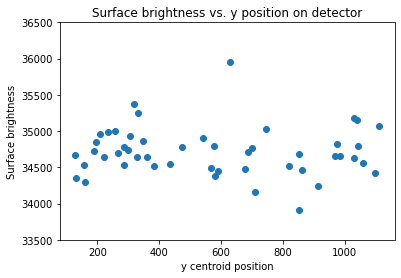

In [10]:
plt.title('Surface brightness vs. y position on detector')
plt.ylim(33500,36500) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['aperture_sum_bkgsub'], marker='o',linestyle='') #ylim=(30000,40000))
plt.show()

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 